In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib
import warnings
warnings.filterwarnings(action='ignore')  

train = pd.read_csv('./data/FIFA_train.csv')
test = pd.read_csv('./data/FIFA_test.csv')
submission  = pd.read_csv('./data/submission.csv')

## 간단한 전처리

In [2]:
def con_period(x):
    if x == 'Dec 31, 2018' :
        return '2019'
    elif x == 'Jun 30, 2020' :
        return '2020.5'
    elif x == 'Jun 30, 2019' :
        return '2019.5'
    elif x == 'May 31, 2020' :
        return '2020.3333'
    elif x == 'May 31, 2019' :
        return '2019.3333'
    elif x == 'Jan 31, 2019' :
        return '2019.0833'
    elif x == 'Jan 1, 2019' :
        return '2019'
    elif x == 'Jan 12, 2019' :
        return '2019.034'
    elif x == 'Dec 31, 2019' :
        return '2020'
    elif x == 'Jun 1, 2019' :
        return '2019.416'
    else :
        return x

In [3]:
train.contract_until = train.contract_until.apply(con_period).astype('float64')
test.contract_until = test.contract_until.apply(con_period).astype('float64')

In [4]:
train.contract_until -= 2018
test.contract_until -= 2018

In [5]:
train['continent'] = train['continent'].astype('category').cat.codes
test['continent'] = test['continent'].astype('category').cat.codes

train['position'] = train['position'].astype('category').cat.codes
test['position'] = test['position'].astype('category').cat.codes

train['prefer_foot'] = train['prefer_foot'].astype('category').cat.codes
test['prefer_foot'] = test['prefer_foot'].astype('category').cat.codes

In [6]:
train.value = np.log1p(train.value)

In [7]:
train = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data = train)
test = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data = test)

In [8]:
train[['age','reputation', 'stat_potential']] = np.log1p(train[['age','reputation', 'stat_potential']])
test[['age','reputation', 'stat_potential']] = np.log1p(test[['age','reputation', 'stat_potential']])

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = StandardScaler()

std_feature = ['age', 'contract_until', 'reputation', 'stat_overall',
       'stat_potential', 'stat_skill_moves']

train[std_feature] = pd.DataFrame(scaler.fit_transform(train[std_feature]), columns =  train[std_feature].columns)
test[std_feature] = pd.DataFrame(scaler.fit_transform(test[std_feature]), columns = test[std_feature].columns)

In [10]:
feature = ['age', 'contract_until', 'reputation', 'stat_overall',
       'stat_potential', 'stat_skill_moves', 'continent_0',
       'continent_1', 'continent_2', 'continent_3', 'continent_4',
       'position_0', 'position_1', 'position_2', 'position_3', 'prefer_foot_0',
       'prefer_foot_1']

x_train = train[feature]
y_train = train['value']
x_test = test[feature]

## 모델링

In [12]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from tensorflow.keras import layers, callbacks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam

In [13]:
def fifa_rmse(true_df, pred_df):
    gt = true_df.to_numpy()
    pr = pred_df.to_numpy()

    score = np.sqrt(np.mean(np.square(gt - pr)))
    score = round(score, 7)
    return score

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=10,    
    min_delta=0.001, 
    restore_best_weights=True,
)

In [30]:
from sklearn.model_selection import train_test_split

# train_test_split
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

In [42]:
lr = 0.0001 #0.0003 #0.001
nn_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(train_x.shape[1],)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1)
    ])

nn_model.compile(optimizer=Adam(lr),   #'rmsprop'
              loss='mse'
                 )

history = nn_model.fit(x_train, y_train, callbacks=early_stopping, verbose=2, validation_data=(x_train, y_train), epochs=1000, batch_size=128)

Epoch 1/1000
70/70 - 0s - loss: 151.1727 - val_loss: 51.8463
Epoch 2/1000
70/70 - 0s - loss: 11.5268 - val_loss: 4.6287
Epoch 3/1000
70/70 - 0s - loss: 3.5467 - val_loss: 2.7759
Epoch 4/1000
70/70 - 0s - loss: 2.3417 - val_loss: 1.9415
Epoch 5/1000
70/70 - 0s - loss: 1.6126 - val_loss: 1.2892
Epoch 6/1000
70/70 - 0s - loss: 1.0477 - val_loss: 0.8107
Epoch 7/1000
70/70 - 0s - loss: 0.6493 - val_loss: 0.4997
Epoch 8/1000
70/70 - 0s - loss: 0.4138 - val_loss: 0.3321
Epoch 9/1000
70/70 - 0s - loss: 0.2867 - val_loss: 0.2429
Epoch 10/1000
70/70 - 0s - loss: 0.2193 - val_loss: 0.1929
Epoch 11/1000
70/70 - 0s - loss: 0.1733 - val_loss: 0.1545
Epoch 12/1000
70/70 - 0s - loss: 0.1398 - val_loss: 0.1276
Epoch 13/1000
70/70 - 0s - loss: 0.1173 - val_loss: 0.1047
Epoch 14/1000
70/70 - 0s - loss: 0.0990 - val_loss: 0.0930
Epoch 15/1000
70/70 - 0s - loss: 0.0858 - val_loss: 0.0803
Epoch 16/1000
70/70 - 0s - loss: 0.0760 - val_loss: 0.0696
Epoch 17/1000
70/70 - 0s - loss: 0.0676 - val_loss: 0.0633
Ep

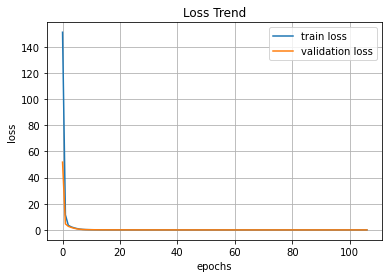

In [43]:
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [44]:
pred = nn_model.predict(val_x)
pred_df = pd.DataFrame(pred)
valy_df = pd.DataFrame(val_y).reset_index(drop=True)
rmse_score = fifa_rmse(valy_df, pred_df)
rmse_score

0.0958442

In [45]:
pred_nn = np.expm1(nn_model.predict(x_test))
submission['value'] = pred_nn
submission.to_csv('submit_nn.csv', index=False)

<모델 저장하기>

In [ ]:
nn_model.save('./model/nn_model.h5')
#nn_model = load_model('./model/nn_model.h5')